# Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create output directory if it doesn't exist

In [ ]:
output_dir = 'output_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clean up any existing visualization files
visualization_files = [
    f"{output_dir}/market_share_pie.png",
    f"{output_dir}/top_5_market_size.png",
    f"{output_dir}/market_segmentation.png"
]

for file_path in visualization_files:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Removed existing file: {file_path}")

# Load and Process Data

In [ ]:
# Load the datasets
tv_df = pd.read_csv("input_data/estat_isoc_ci_dev_i_en.csv")
beds_df = pd.read_csv("input_data/estat_tour_cap_nat_en.csv")

# Process beds dataset
beds_df = beds_df[['geo','TIME_PERIOD','accomunit', 'unit', 'nace_r2','OBS_VALUE', 'OBS_FLAG']]

# Filter beds data
beds_df_2016 = beds_df[(beds_df['accomunit'] == 'BEDPL') & 
                       (beds_df['unit'] == 'NR') & 
                       (beds_df['nace_r2'] == 'I551') & 
                       (beds_df['TIME_PERIOD'] == 2016)]

# Clean beds data
beds_df_2016 = beds_df_2016[~beds_df_2016['geo'].str.contains('EA|EU')]
beds_df_2016['OBS_VALUE'] = beds_df_2016['OBS_VALUE'].replace(':', np.nan).astype(float)
beds_df_2016 = beds_df_2016.dropna(subset=['OBS_VALUE'])
beds_df_2016 = beds_df_2016[~beds_df_2016['OBS_FLAG'].isin(['u', 'bu', 'b'])] # found that there was "b" value in the data. Assumed that it should be tghe same as "bu" and "u" values

# Process TV dataset
tv_df = tv_df[['geo','ind_type','indic_is', 'unit', 'TIME_PERIOD','OBS_VALUE', 'OBS_FLAG']]

# Filter TV data
tv_df_2016 = tv_df[(tv_df['ind_type'] == 'IND_TOTAL') & 
                   (tv_df['indic_is'] == 'I_IUG_TV') & 
                   (tv_df['unit'] == 'PC_IND') & 
                   (tv_df['TIME_PERIOD'] == 2016)]

# Clean TV data
tv_df_2016 = tv_df_2016[~tv_df_2016['geo'].str.contains('EA|EU')]
tv_df_2016 = tv_df_2016[~tv_df_2016['OBS_FLAG'].isin(['u', 'bu', 'b'])] # found that there was "b" value in the data. Assumed that it should be tghe same as "bu" and "u" values

# Merge datasets
geo_merged = pd.merge(beds_df_2016, tv_df_2016, on='geo', how='left', suffixes=('_beds', '_device'))
geo_merged = geo_merged[['geo', 'OBS_VALUE_beds', 'OBS_VALUE_device']]
geo_merged.columns = ['Country Code', 'Number of Bed-places', 'Percentage of individuals']

# Remove rows with missing TV data # for simplicity, i dropped the rows with missing TV data for 5 countries. One of them was ranked 6 based on bed places. It is not best approach. I could have used data from 2015 or 2017. But I wanted to keep the code simple and easy to understand.
# For simplicity i will remove rows where tv related data is not available. However, a better solution would be to fill the missing values with previous year data or some other method.
# Especially i am removing one country "TR" which is Turkey, even though it ranks 6 on the list for bed places, it has no data for TV usage.
geo_merged = geo_merged.dropna(subset=['Percentage of individuals'])


# Q1 Output csv saved

In [5]:
# Save merged data to CSV
csv_file_path = 'output_data/geo_beds_tv_df.csv'
if os.path.exists(csv_file_path):
    os.remove(csv_file_path)
    print(f"Removed existing file: {csv_file_path}")

# Save only the required columns to CSV (exclude Estimated Market Size)
geo_merged.to_csv(csv_file_path, index=False)


Removed existing file: output_data/geo_beds_tv_df.csv


# Q2: Visualization 

In [7]:
# Calculate estimated market size and rank countries for visualization
geo_merged['Estimated Market Size'] = (geo_merged['Percentage of individuals'] / 100) * geo_merged['Number of Bed-places']
ranked_data = geo_merged.sort_values(by='Estimated Market Size', ascending=False)
ranked_data['Market Size Rank'] = range(1, len(ranked_data) + 1)


## Visualization 1

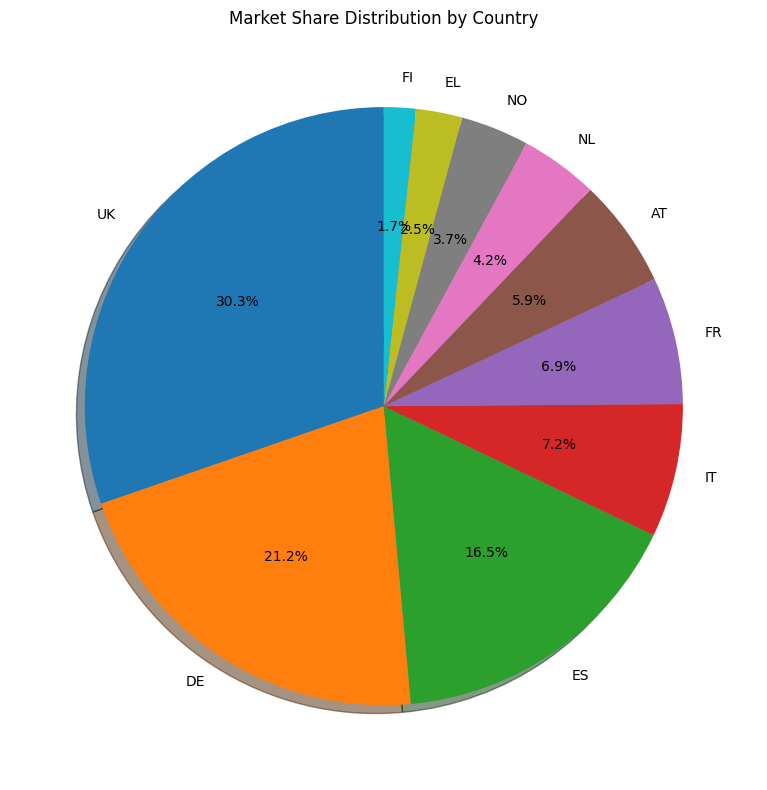

In [8]:
# Visualization 1: Market Share Pie Chart (no clustering)
plt.figure(figsize=(10, 8))
plt.pie(ranked_data.sort_values(by='Estimated Market Size', ascending=False).head(10)['Estimated Market Size'], 
        labels=ranked_data.sort_values(by='Estimated Market Size', ascending=False).head(10)['Country Code'], 
        autopct='%1.1f%%',
        startangle=90,
        shadow=True)
plt.title('Market Share Distribution by Country')
plt.tight_layout()
plt.savefig(f'{output_dir}/market_share_pie.png')
plt.show()


## Visualization 2

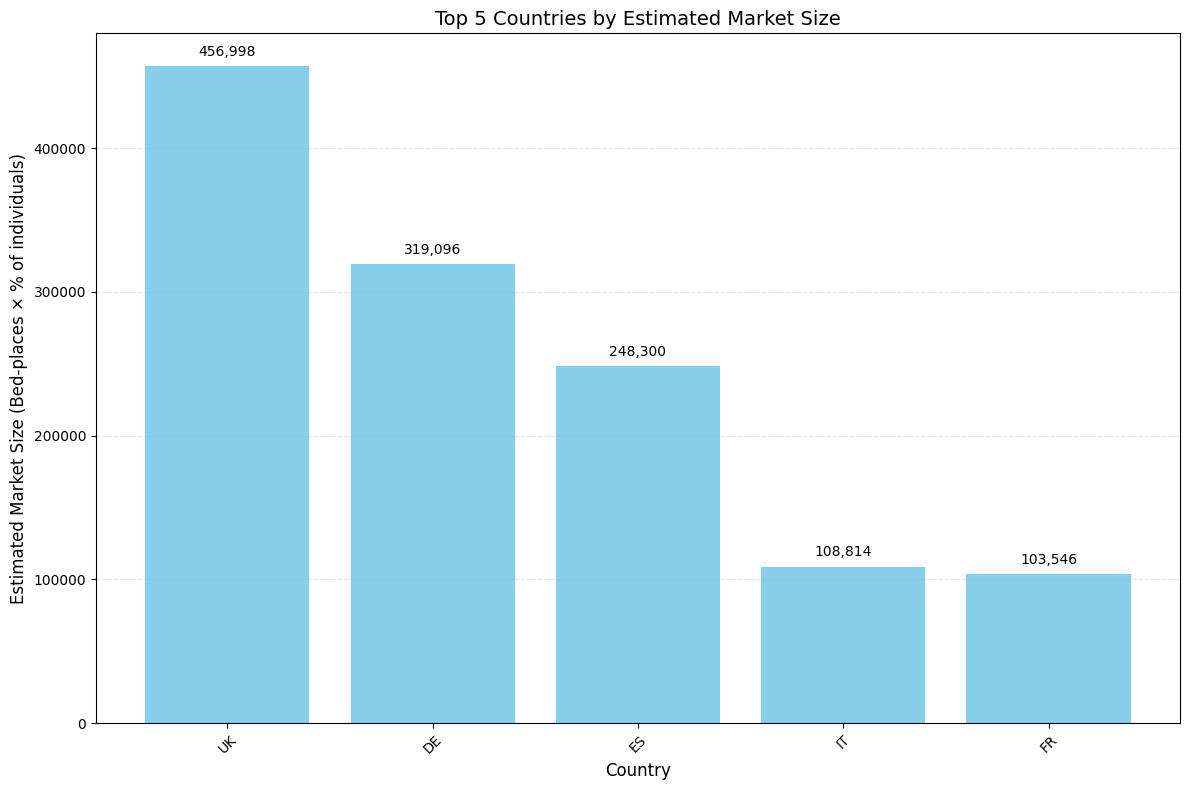

In [9]:
# Visualization 2: Bar chart of top 5 countries by estimated market size (no clustering)
top_5 = ranked_data.sort_values(by='Estimated Market Size', ascending=False).head(5)
plt.figure(figsize=(12, 8))
bars = plt.bar(top_5['Country Code'], top_5['Estimated Market Size'], color='skyblue')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5000,
            f'{int(height):,}',
            ha='center', va='bottom', rotation=0)

plt.title('Top 5 Countries by Estimated Market Size', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Estimated Market Size (Bed-places × % of individuals)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f'{output_dir}/top_5_market_size.png')
plt.show()


## Visualization 3

In [10]:
# Now perform clustering for Visualization 3
# Prepare data for clustering
cluster_data = ranked_data[['Number of Bed-places', 'Percentage of individuals']]

# Scale the data
scaler = StandardScaler()
scaled_cluster_data = scaler.fit_transform(cluster_data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
ranked_data['Cluster'] = kmeans.fit_predict(scaled_cluster_data)

# Create cluster labels dictionary for interpretation
cluster_labels = {
    0: 'Low-Low (Avoid Initially)',
    1: 'High-Low (Secondary Target)',
    2: 'High-High (Primary Target)'
}

# Map cluster numbers to descriptive labels
ranked_data['Cluster Label'] = ranked_data['Cluster'].map(cluster_labels)


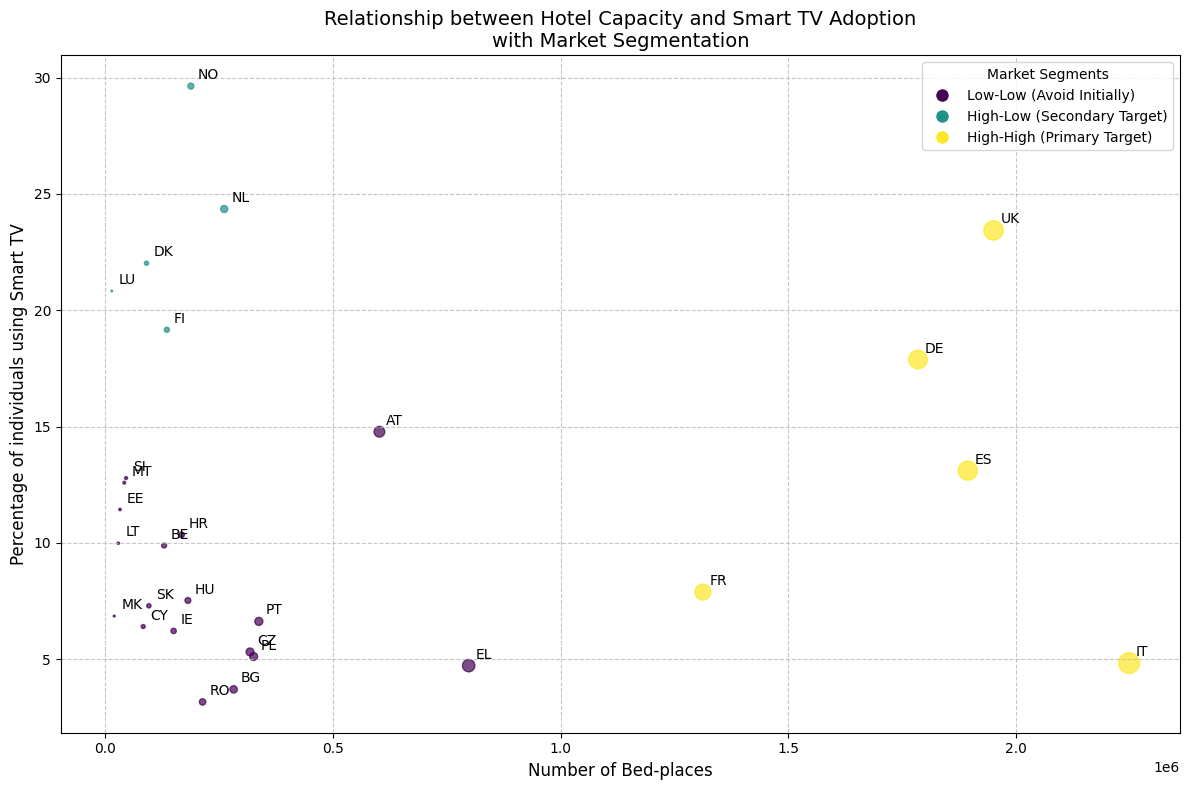

In [11]:
# Visualization 3: Scatter plot with clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(ranked_data['Number of Bed-places'], 
                     ranked_data['Percentage of individuals'], 
                     s=ranked_data['Number of Bed-places']/10000, 
                     c=ranked_data['Cluster'],
                     cmap='viridis',
                     alpha=0.7)

# Add country labels
for i, row in ranked_data.iterrows():
    plt.annotate(row['Country Code'], 
                (row['Number of Bed-places'], row['Percentage of individuals']),
                xytext=(5, 5), 
                textcoords='offset points')

# Add legend for clusters
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=scatter.cmap(scatter.norm(i)), 
                             markersize=10, label=label) 
                  for i, label in cluster_labels.items()]

plt.legend(handles=legend_elements, title='Market Segments', loc='upper right')
plt.title('Relationship between Hotel Capacity and Smart TV Adoption\nwith Market Segmentation', fontsize=14)
plt.xlabel('Number of Bed-places', fontsize=12)
plt.ylabel('Percentage of individuals using Smart TV', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'{output_dir}/market_segmentation.png')
plt.show()


In [12]:
# Print cluster analysis summary
cluster_summary = ranked_data.groupby('Cluster')[['Number of Bed-places', 'Percentage of individuals', 'Estimated Market Size']].mean()
cluster_summary['Countries'] = ranked_data.groupby('Cluster')['Country Code'].apply(list)
print("\n=== CLUSTER ANALYSIS SUMMARY ===")
for cluster, row in cluster_summary.iterrows():
    print(f"\nCluster {cluster} - {cluster_labels[cluster]}:")
    print(f"  Average Bed-places: {row['Number of Bed-places']:.2f}")
    print(f"  Average Smart TV %: {row['Percentage of individuals']:.2f}%")
    print(f"  Average Market Size: {row['Estimated Market Size']:.2f}")
    print(f"  Countries: {', '.join(row['Countries'])}")



=== CLUSTER ANALYSIS SUMMARY ===

Cluster 0 - Low-Low (Avoid Initially):
  Average Bed-places: 213961.89
  Average Smart TV %: 8.05%
  Average Market Size: 15795.40
  Countries: AT, EL, PT, HR, CZ, PL, HU, BE, BG, IE, SK, RO, SI, CY, MT, EE, LT, MK

Cluster 1 - High-Low (Secondary Target):
  Average Bed-places: 137809.80
  Average Smart TV %: 23.20%
  Average Market Size: 33616.08
  Countries: NL, NO, FI, DK, LU

Cluster 2 - High-High (Primary Target):
  Average Bed-places: 1837942.80
  Average Smart TV %: 13.43%
  Average Market Size: 247351.11
  Countries: UK, DE, ES, IT, FR
